# Lasso Regularized GLM for Feature Selection in Python

## Introduction

Welcome to our tutorial on using the Lasso Regularized Generalized Linear Model (GLM) for feature selection in Python! Feature selection is a critical step in machine learning, helping us identify the most important variables from a dataset, making models more accurate and easier to understand.

## Description

The Lasso Regularized GLM is a powerful variant of the traditional GLM. It adds a unique twist - the L1 regularization penalty (Lasso regularization). This penalty encourages some coefficients to become exactly zero, effectively excluding irrelevant features from the model. As a result, the Lasso Regularized GLM becomes an excellent tool for feature selection, especially in datasets with many variables.

In this tutorial, we'll build a user-friendly Python class called "LassoFeatureSelection" that harnesses the Lasso Regularized GLM to perform feature selection. The class can handle different types of data, like pandas DataFrames and numpy arrays, making it super flexible and compatible with various data formats.

Please note that one limitation of the lasso is that it treats the levels of a categorical predictor individually. However, this issue can be addressed by utilizing the `TreeDiscretizer`, which automatically bins numerical variables and groups the levels of categorical variables.

## Key Features of the "LassoFeatureSelection" Class

1. **Automated Intercept Handling:** Our class automatically adds an intercept column to the input data if it's missing. It then checks if the intercept is statistically significant and keeps it only if necessary.

2. **Model Selection:** We use a grid search cross-validation approach to find the best regularization parameter (alpha) for the Lasso Regularized GLM. Users can choose from two scoring options: the Bayesian Information Criterion (BIC) or the mean cross-validation score (deviance). The BIC is much faster.

3. **Transparent Feature Selection:** After fitting the "LassoFeatureSelection" model, you can access the selected features. This lets you understand which variables are the most crucial in the final model.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error

from arfs.feature_selection.lasso import LassoFeatureSelection
from arfs.preprocessing import PatsyTransformer
import arfs.feature_selection as arfsfs


def plot_y_vs_X(
    X: pd.DataFrame, y: pd.Series, ncols: int = 2, figsize: tuple = (10, 10)
) -> plt.Figure:
    """
    Create subplots of scatter plots showing the relationship between each column in X and the target variable y.

    Parameters
    ----------
        X : pd.DataFrame
            The input DataFrame containing the predictor variables.
        y : pd.Series
            The target variable to be plotted against.
        ncols : int, optional (default: 2)
            The number of columns in the subplot grid.
        figsize : tuple, optional (default: (10, 10))
            The size of the figure (width, height) in inches.

    Returns
    -------
        plt.Figure
            The generated Figure object containing the scatter plots.
    """

    n_rows, ncols_to_plot = divmod(X.shape[1], ncols)
    n_rows += int(ncols_to_plot > 0)

    # Create figure and axes
    f, axs = plt.subplots(nrows=n_rows, ncols=ncols, figsize=figsize)

    # Iterate through columns and plot against y
    for ax, col in zip(axs.flat, X.columns):
        ax.scatter(X[col], y, alpha=0.1)
        ax.set_title(col)

    # Remove any unused subplots
    for ax in axs.flat[len(X.columns) :]:
        ax.set_axis_off()

    # Display the figure
    plt.tight_layout()
    return f

## Linear model

The main goal here is not to build a detailed model for the data, but rather to identify the most important predictors. We will check how well the feature selection process can distinguish between meaningful predictors and random noise.

The true coefficient of the linear data generating process are:
 [ 0.         77.90364383  0.          0.         63.70230035  0.
 95.59499715 43.86990345  0.          4.11861919]


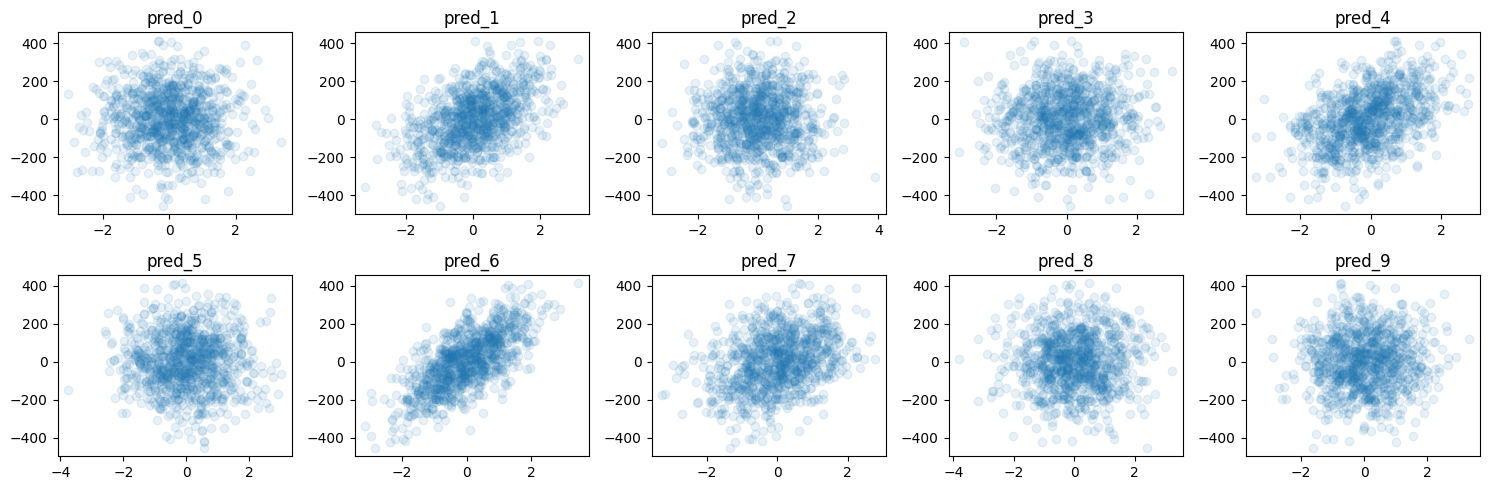

In [42]:
bias = 7.0
X, y, true_coef = make_regression(
    n_samples=2_000,
    n_features=10,
    n_informative=5,
    noise=1,
    random_state=8,
    bias=bias,
    coef=True,
)
X = pd.DataFrame(X)
X.columns = [f"pred_{i}" for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

print(f"The true coefficient of the linear data generating process are:\n {true_coef}")
f = plot_y_vs_X(X_train, y_train, ncols=5, figsize=(15, 5))

In [43]:
# family should be: "gaussian", "poisson", "gamma", "negativebinomial", "binomial", "tweedie"
selector = LassoFeatureSelection(n_iterations=10, family="gaussian", score="bic")
selector.fit(X=X_train, y=y_train, sample_weight=None)
selector.get_feature_names_out()

Index(['Intercept', 'pred_1', 'pred_4', 'pred_6', 'pred_7', 'pred_9'], dtype='object')

In [44]:
true_coef = pd.Series(true_coef)
true_coef.index = X.columns
true_coef = pd.Series({**{"intercept": bias}, **true_coef})
true_coef

intercept     7.000000
pred_0        0.000000
pred_1       77.903644
pred_2        0.000000
pred_3        0.000000
pred_4       63.702300
pred_5        0.000000
pred_6       95.594997
pred_7       43.869903
pred_8        0.000000
pred_9        4.118619
dtype: float64

In [45]:
selector.transform(X_test).head()

,Intercept,pred_1,pred_4,pred_6,pred_7,pred_9
1860,1.0,1.091750,-0.015868,0.231947,-0.998250,0.041597
353,1.0,-0.871767,2.557578,-0.026118,0.936062,0.533048
1333,1.0,1.147664,0.678622,-0.313260,-1.717187,0.228773
905,1.0,2.247261,-0.008657,0.354843,0.151635,2.047569
1289,1.0,-0.061458,-1.429949,-1.012678,-1.070863,0.768713


In [46]:
selector.feature_names_in_

Index(['Intercept', 'pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5',
       'pred_6', 'pred_7', 'pred_8', 'pred_9'],
      dtype='object')

In [47]:
selector.support_

array([ True, False,  True, False, False,  True, False,  True,  True,
       False,  True])

The exciting part is that lasso, despite potential mismatches in the distribution, can still perform remarkably well. It means that even if the data does not perfectly follow a certain pattern, lasso might successfully identify relevant predictors and filter out irrelevant ones.

In [48]:
selector.get_feature_names_out()

Index(['Intercept', 'pred_1', 'pred_4', 'pred_6', 'pred_7', 'pred_9'], dtype='object')

we can even check the value of the coefficients, even though is not the intended use (the ultimate output is given by the method `.get_feature_names_out()`)

In [49]:
selector.best_estimator_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          1.0435
Method:                   elastic_net   Log-Likelihood:                -1437.2
Date:                Sat, 05 Aug 2023   Deviance:                       1037.2
Time:                        23:57:51   Pearson chi2:                 1.04e+03
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0127      0.032    215.952      0.000       6.949       7.076
pred_0              0          0        nan        nan           0           0
pred_1        77.8866      0.033   2375.009      0.000      77.822      77.951
pred_2              0          0        nan        nan           0           0
pred_3              0          0        nan        nan           0           0
pred_4        63.7313      0.033   1958.221      0.000      63.667      63.795
pred_5              0          0        nan        nan           0           0
pred_6        95.5690      0.032   2959.937      0.000      95.506      95.632
pred_7        43.9089      0.033   1325.779      0.000      43.844      43.974
pred_8              0          0        nan        nan           0           0
pred_9         4.0589      0.033    123.946      0.000       3.995       4.123
==============================================================================
"""

## A toy example using the selector in a pipeline

In [50]:
# Create a pipeline with LassoFeatureSelection and LinearRegression
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("selector", LassoFeatureSelection(n_iterations=10, score="bic")),
        ("linear_regression", LinearRegression()),
    ]
)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.9917846740502066


In [51]:
arfsfs.make_fs_summary(pipeline)

,predictor,scaler,selector,linear_regression
0,pred_0,nan,0,nan
1,pred_1,nan,1,nan
2,pred_2,nan,0,nan
3,pred_3,nan,0,nan
4,pred_4,nan,1,nan
5,pred_5,nan,0,nan
6,pred_6,nan,1,nan
7,pred_7,nan,1,nan
8,pred_8,nan,0,nan
9,pred_9,nan,1,nan


In [52]:
pipeline.named_steps["selector"].get_feature_names_out()

Index(['Intercept', 'pred_1', 'pred_4', 'pred_6', 'pred_7', 'pred_9'], dtype='object')

beyond the feature selection quality, we can even check if the model itself is good.

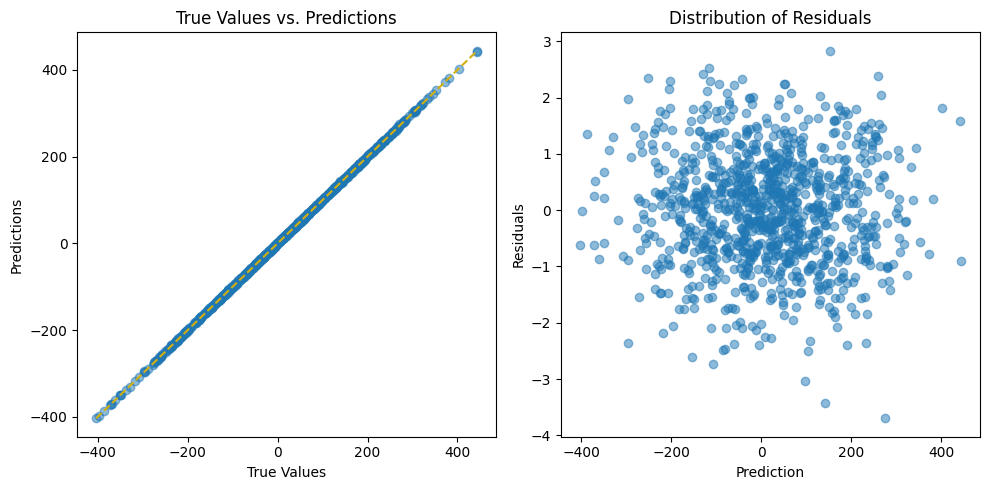

In [53]:
import seaborn as sns

# Plot the predictions and residuals
plt.figure(figsize=(10, 5))

# Plot predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="#d1ae11",
    linestyle="--",
)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs. Predictions")

# Plot residuals
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y=residuals, x=y_pred, alpha=0.5)
plt.ylabel("Residuals")
plt.xlabel("Prediction")
plt.title("Distribution of Residuals")

plt.tight_layout()
plt.show();

## Poisson toy example

The loss can be one of the typical GLM losses: "gaussian", "poisson", "gamma", "negativebinomial", "binomial", "tweedie".

The true coefficient of the linear data generating process are:
 [ 0.         77.90364383  0.          0.         63.70230035  0.
 95.59499715 43.86990345  0.          4.11861919]


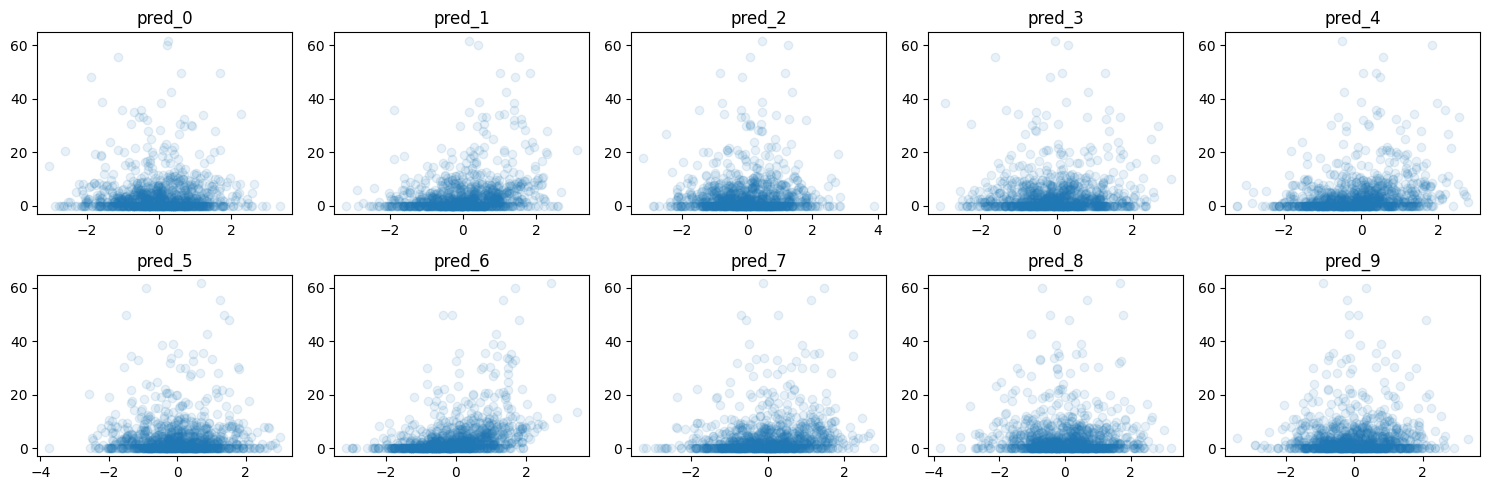

In [54]:
# Generate synthetic data with Poisson-distributed target variable
bias = 1
X, y, true_coef = make_regression(
    n_samples=2_000,
    n_features=10,
    n_informative=5,
    noise=1,
    random_state=8,
    bias=bias,
    coef=True,
)
y = (y - y.mean()) / y.std()
y = np.exp(y)  # Transform to positive values for Poisson distribution
y = np.random.poisson(y)  # Add Poisson noise to the target variable
# dummy sample weight (e.g. exposure), smallest being 30 days
w = np.random.uniform(30 / 365, 1, size=len(y))
# make the count a Poisson rate (frequency)
y = y / w

X = pd.DataFrame(X)
X.columns = [f"pred_{i}" for i in range(X.shape[1])]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.5, random_state=42
)

print(f"The true coefficient of the linear data generating process are:\n {true_coef}")

f = plot_y_vs_X(X_train, y_train, ncols=5, figsize=(15, 5))

In [55]:
y

array([0.        , 5.94167417, 1.24007121, ..., 8.2468012 , 3.51277289,
       2.61216374])

In [56]:
# Create a pipeline with LassoFeatureSelection and LinearRegression
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "selector",
            LassoFeatureSelection(
                n_iterations=10, score="bic", family="poisson", fit_intercept=True
            ),
        ),
        ("glm", PoissonRegressor()),
    ]
)

# Fit the pipeline to the training data
pipeline.fit(
    X_train, y_train, selector__sample_weight=w_train, glm__sample_weight=w_train
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', LassoFeatureSelection(family='poisson')),
                ('glm', PoissonRegressor())])

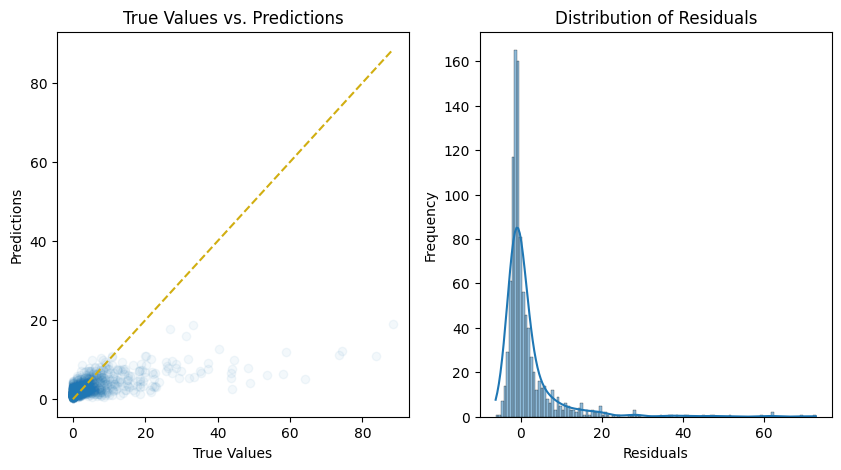

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Plot the predictions and residuals
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot predictions
axs[0].scatter(y_test, y_pred, alpha=0.05)
axs[0].plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="#d1ae11",
    linestyle="--",
)
axs[0].set_xlabel("True Values")
axs[0].set_ylabel("Predictions")
axs[0].set_title("True Values vs. Predictions")


# Plot residuals
axs[1] = sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Distribution of Residuals")

plt.show();


In [58]:
true_coef = pd.Series(true_coef)
true_coef.index = X.columns
true_coef = pd.Series({**{"intercept": bias}, **true_coef})
true_coef

intercept     1.000000
pred_0        0.000000
pred_1       77.903644
pred_2        0.000000
pred_3        0.000000
pred_4       63.702300
pred_5        0.000000
pred_6       95.594997
pred_7       43.869903
pred_8        0.000000
pred_9        4.118619
dtype: float64

the selected predictors are

In [59]:
pipeline.named_steps["selector"].get_feature_names_out()

Index(['Intercept', 'pred_1', 'pred_4', 'pred_6', 'pred_7'], dtype='object')

In [60]:
arfsfs.make_fs_summary(pipeline)

,predictor,scaler,selector,glm
0,pred_0,nan,0,nan
1,pred_1,nan,1,nan
2,pred_2,nan,0,nan
3,pred_3,nan,0,nan
4,pred_4,nan,1,nan
5,pred_5,nan,0,nan
6,pred_6,nan,1,nan
7,pred_7,nan,1,nan
8,pred_8,nan,0,nan
9,pred_9,nan,0,nan


In [61]:
pipeline.named_steps["selector"].best_estimator_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      995
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:                -1214.3
Date:                Sat, 05 Aug 2023   Deviance:                       1445.8
Time:                        23:58:06   Pearson chi2:                 2.09e+03
No. Iterations:                    25   Pseudo R-squ. (CS):             0.7747
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5474      0.037     14.858      0.000       0.475       0.620
pred_0              0          0        nan        nan           0           0
pred_1         0.5276      0.026     19.991      0.000       0.476       0.579
pred_2              0          0        nan        nan           0           0
pred_3              0          0        nan        nan           0           0
pred_4         0.4029      0.027     14.980      0.000       0.350       0.456
pred_5              0          0        nan        nan           0           0
pred_6         0.6627      0.025     26.120      0.000       0.613       0.712
pred_7         0.3304      0.028     11.947      0.000       0.276       0.385
pred_8              0          0        nan        nan           0           0
pred_9              0          0        nan        nan           0           0
==============================================================================
"""

## Categorical variable, missing values and miss-specified distribution

When working with the `PatsyTransformer`, it's essential to handle missing values in a specific way for categorical variables. To do this, we convert missing values into a string representation, as the native support of NaN in numpy is not yet fully implemented for general arrays.

Keep in mind that the dummy dataset we are using in this context does not necessarily correspond to any specific distribution assumption, such as the exponential family. However, for the purpose of feature selection, this might not pose a significant obstacle. The feature selection process can still be effective in identifying relevant predictors, even when the data does not precisely follow a specific distribution pattern.

### Classical approach

Unfortunatly, Patsy is not yet pickable, I'll present to equivalent approaches, one pickable approach and another using the Patsy transformer.

In [62]:
from arfs.utils import _make_corr_dataset_regression

X, y, w = _make_corr_dataset_regression(size=2_000)
# a dummy categorical variable with as many levels as rows
# and with zero variance
X = X.drop(columns=["var10", "var11"])

In [63]:
# select all cols considered as categorical by numpy's standard'
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as columns_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_features = columns_selector(dtype_include=["category", "object", "boolean"])
num_features = columns_selector(dtype_include=np.number)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="Missing_Value")),
           ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ], 
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")



# Create the pipeline
pipeline = Pipeline(
    [
        ("preprocess", preprocessor), 
        (
            "selector",
            LassoFeatureSelection(
                n_iterations=10, score="bic", family="gaussian", fit_intercept=True
            ),
        ),
    ]
)

# Fit the model
pipeline.fit(X, y)  # , selector__sample_weight=w)

Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3ce74b430>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing_Value',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3ce74b640>)],
                                   verbose_feature_names_out=False)),
                ('selector', LassoFeatureSelection())])

In [64]:
arfsfs.make_fs_summary(pipeline)

,predictor,preprocess,selector
0,var0,nan,1
1,var1,nan,1
2,var2,nan,1
3,var3,nan,1
4,var4,nan,1
5,var5,nan,1
6,var6,nan,0
7,var7,nan,0
8,var8,nan,0
9,var9,nan,0


In [65]:
pipeline.named_steps["selector"].get_feature_names_out()

Index(['Intercept', 'var0', 'var1', 'var2', 'var3', 'var4', 'var5'], dtype='object')

In [66]:
pipeline.named_steps["selector"].feature_names_in_

Index(['Intercept', 'var0', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6',
       'var7', 'var8', 'var9', 'var12', 'nice_guys_Alien', 'nice_guys_Bane',
       'nice_guys_Bejita', 'nice_guys_Bender', 'nice_guys_Bias',
       'nice_guys_Blackbeard', 'nice_guys_Cartman', 'nice_guys_Cell',
       'nice_guys_Coldplay', 'nice_guys_Creationist', 'nice_guys_Dracula',
       'nice_guys_Drago', 'nice_guys_Excel', 'nice_guys_Fry',
       'nice_guys_Garry', 'nice_guys_Geoffrey', 'nice_guys_Goldfinder',
       'nice_guys_Gruber', 'nice_guys_Human', 'nice_guys_Imaginedragons',
       'nice_guys_KeyserSoze', 'nice_guys_Klaue', 'nice_guys_Krueger',
       'nice_guys_Lecter', 'nice_guys_Luthor', 'nice_guys_MarkZ',
       'nice_guys_Morty', 'nice_guys_Platist', 'nice_guys_Rick',
       'nice_guys_SAS', 'nice_guys_Scrum', 'nice_guys_Terminator',
       'nice_guys_Thanos', 'nice_guys_Tinkywinky', 'nice_guys_Vador',
       'nice_guys_Variance'],
      dtype='object')

Using the Patsy transformer

In [67]:
cat_features = columns_selector(dtype_include=["category", "object", "boolean"])
num_features = columns_selector(dtype_include=np.number)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="median")), ("scaler", StandardScaler())]
)

# either drop the NA or impute them
imputer = ColumnTransformer(
    transformers=[
        (
            "cat",
            SimpleImputer(
                missing_values=np.nan, strategy="constant", fill_value="Missing_Value"
            ),
            cat_features,
        ),
        ("num", numeric_transformer, num_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Create the pipeline
pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("preprocess", PatsyTransformer()), 
        (
            "selector",
            LassoFeatureSelection(
                n_iterations=10, score="bic", family="gaussian", fit_intercept=True
            ),
        ),
    ]
)

# Fit the model
pipeline.fit(X, y)  # , selector__sample_weight=w)


Elastic net fitting did not converge
Elastic net fitting did not converge


Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  SimpleImputer(fill_value='Missing_Value',
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3ce748fa0>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3ce74b5b0>)],
                                   verbose_feature_names_out=False)),
                ('preprocess',
                 PatsyTransformer(formula='nice_guys + var0 + var1 + var12 + '
                                          'var2 + var3 + var4 + var5 + var6 + '
                                          'var7 + var8 + var9')),
                ('selector', LassoFeatureSelection())])

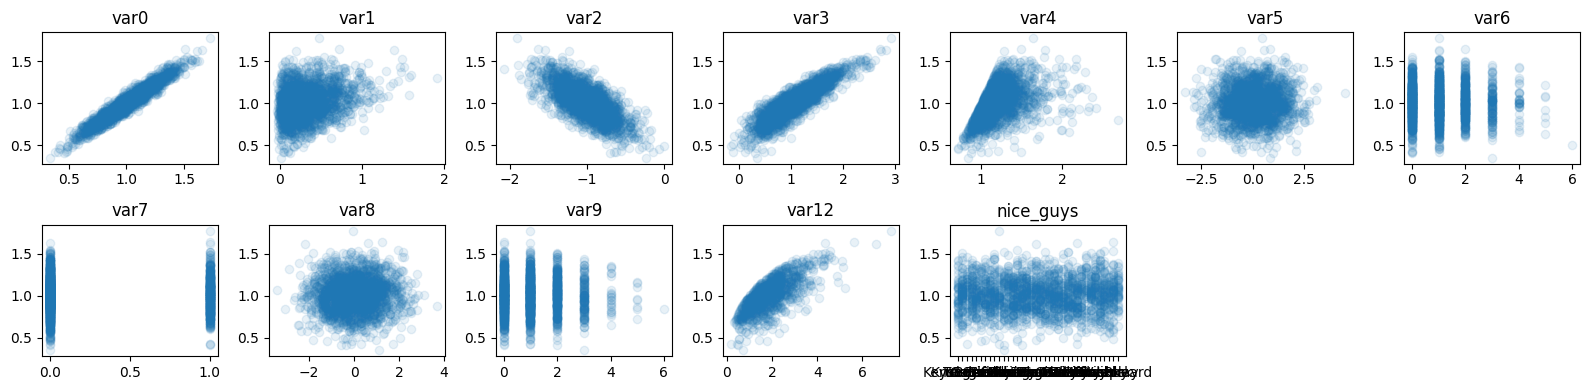

In [68]:
f = plot_y_vs_X(X, y, ncols=7, figsize=(16, 4))

The genuine predictors are : `var0`, `var1`, `var2`, `var3`, `var4` and `var12`

In [69]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var12,nice_guys
0,1.091810,0.489242,-1.235042,1.443517,1.084685,0.716430,2,0,0.532132,1,2.212539,Krueger
1,0.976880,0.235321,-1.033447,0.569663,1.017232,1.155733,1,1,0.147567,1,0.919993,KeyserSoze
2,1.161955,0.422190,-1.249014,1.210296,1.218725,-3.307900,1,0,-0.295357,2,1.506035,Klaue
3,1.335830,0.300262,-1.282522,1.693665,1.332802,-0.151363,1,0,-0.740745,3,NaN,Bane
4,0.974240,0.107206,-0.713734,0.911713,1.107156,-2.875773,2,0,0.112322,1,1.971962,Krueger


In [70]:
arfsfs.make_fs_summary(pipeline)

,predictor,imputer,preprocess,selector
0,var0,nan,nan,1
1,var1,nan,nan,1
2,var2,nan,nan,1
3,var3,nan,nan,1
4,var4,nan,nan,1
5,var5,nan,nan,1
6,var6,nan,nan,0
7,var7,nan,nan,0
8,var8,nan,nan,0
9,var9,nan,nan,0


In [71]:
pipeline.named_steps["selector"].get_feature_names_out()

Index(['Intercept', 'var0', 'var1', 'var12', 'var2', 'var3', 'var4', 'var5'], dtype='object')

In [72]:
pipeline.named_steps["selector"].support_

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False])

In [73]:
X_trans = pipeline.transform(X)
X_trans.head()

,Intercept,var0,var1,var12,var2,var3,var4,var5
0,1.0,0.410244,0.579520,0.515223,-0.785263,0.844345,-0.518385,0.683297
1,1.0,-0.148030,-0.373188,-1.496868,-0.068675,-1.102092,-0.803974,1.120786
2,1.0,0.750973,0.327939,-0.584584,-0.834928,0.324865,0.049133,-3.324418
3,1.0,1.595568,-0.129529,-0.083170,-0.954037,1.401527,0.532125,-0.180913
4,1.0,-0.160855,-0.853871,0.140719,1.067778,-0.340203,-0.423244,-2.894075


In [74]:
pipeline.named_steps["selector"].feature_names_in_

Index(['Intercept', 'nice_guys[T.Bane]', 'nice_guys[T.Bejita]',
       'nice_guys[T.Bender]', 'nice_guys[T.Bias]', 'nice_guys[T.Blackbeard]',
       'nice_guys[T.Cartman]', 'nice_guys[T.Cell]', 'nice_guys[T.Coldplay]',
       'nice_guys[T.Creationist]', 'nice_guys[T.Dracula]',
       'nice_guys[T.Drago]', 'nice_guys[T.Excel]', 'nice_guys[T.Fry]',
       'nice_guys[T.Garry]', 'nice_guys[T.Geoffrey]',
       'nice_guys[T.Goldfinder]', 'nice_guys[T.Gruber]', 'nice_guys[T.Human]',
       'nice_guys[T.Imaginedragons]', 'nice_guys[T.KeyserSoze]',
       'nice_guys[T.Klaue]', 'nice_guys[T.Krueger]', 'nice_guys[T.Lecter]',
       'nice_guys[T.Luthor]', 'nice_guys[T.MarkZ]', 'nice_guys[T.Morty]',
       'nice_guys[T.Platist]', 'nice_guys[T.Rick]', 'nice_guys[T.SAS]',
       'nice_guys[T.Scrum]', 'nice_guys[T.Terminator]', 'nice_guys[T.Thanos]',
       'nice_guys[T.Tinkywinky]', 'nice_guys[T.Vador]',
       'nice_guys[T.Variance]', 'var0', 'var1', 'var12', 'var2', 'var3',
       'var4', 'var5', 

In [75]:
pipeline.named_steps["selector"].best_estimator_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1992
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                       0.0021507
Method:                   elastic_net   Log-Likelihood:                 3308.1
Date:                Sat, 05 Aug 2023   Deviance:                       4.2841
Time:                        23:58:21   Pearson chi2:                     4.28
No. Iterations:                    49   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.0090      0.001    973.031      0.000       1.007       1.011
nice_guys[T.Bane]                    0          0        nan        nan           0           0
nice_guys[T.Bejita]                  0          0        nan        nan           0           0
nice_guys[T.Bender]                  0          0        nan        nan           0           0
nice_guys[T.Bias]                    0          0        nan        nan           0           0
nice_guys[T.Blackbeard]              0          0        nan        nan           0           0
nice_guys[T.Cartman]                 0          0        nan        nan           0           0
nice_guys[T.Cell]                    0          0        nan        nan           0           0
nice_guys[T.Coldplay]                0          0        nan        nan           0           0
nice_guys[T.Creationist]             0          0        nan        nan           0           0
nice_guys[T.Dracula]                 0          0        nan        nan           0           0
nice_guys[T.Drago]                   0          0        nan        nan           0           0
nice_guys[T.Excel]                   0          0        nan        nan           0           0
nice_guys[T.Fry]                     0          0        nan        nan           0           0
nice_guys[T.Garry]                   0          0        nan        nan           0           0
nice_guys[T.Geoffrey]                0          0        nan        nan           0           0
nice_guys[T.Goldfinder]              0          0        nan        nan           0           0
nice_guys[T.Gruber]                  0          0        nan        nan           0           0
nice_guys[T.Human]                   0          0        nan        nan           0           0
nice_guys[T.Imaginedragons]          0          0        nan        nan           0           0
nice_guys[T.KeyserSoze]              0          0        nan        nan           0           0
nice_guys[T.Klaue]                   0          0        nan        nan           0           0
nice_guys[T.Krueger]                 0          0        nan        nan           0           0
nice_guys[T.Lecter]                  0          0        nan        nan           0           0
nice_guys[T.Luthor]                  0          0        nan        nan           0           0
nice_guys[T.MarkZ]                   0          0        nan        nan           0           0
nice_guys[T.Morty]                   0          0        nan        nan           0           0
nice_guys[T.Platist]                 0          0        nan        nan           0           0
nice_guys[T.Rick]                    0          0        nan        nan           0           0
nice_guys[T

### Advanced approach

We can auto-bin the predictors and group levels. The non-informative predictors will not be binned and their value will be np.nan or np.Inf 

In [76]:
from arfs.preprocessing import TreeDiscretizer, IntervalToMidpoint
from arfs.feature_selection import UniqueValuesThreshold, MissingValueThreshold

cat_features = columns_selector(dtype_include=["category", "object", "boolean"])
num_features = columns_selector(dtype_include=np.number)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ], 
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")


# Create the pipeline
pipeline = Pipeline(
    [
        (
            "disctretizer",
            TreeDiscretizer(bin_features="all", n_bins=10, boost_params={"min_split_gain": 0.05}),
        ),
        ("midpointer", IntervalToMidpoint()),
        ("zero_variance", UniqueValuesThreshold()),
        # the treediscretization might introduce NaN for pure noise columns
        ("missing", MissingValueThreshold(0.05)),
        ("preprocess", preprocessor), 
        (
            "selector",
            LassoFeatureSelection(
                n_iterations=10, score="bic", family="gaussian", fit_intercept=True
            ),
        ),
    ]
)

pipeline.fit(X, y)


Elastic net fitting did not converge


Pipeline(steps=[('disctretizer',
                 TreeDiscretizer(bin_features=['var0', 'var1', 'var2', 'var3',
                                               'var4', 'var5', 'var6', 'var7',
                                               'var8', 'var9', 'var12',
                                               'nice_guys'],
                                 boost_params={'max_leaf': 10,
                                               'min_split_gain': 0.05,
                                               'num_boost_round': 1,
                                               'objective': 'RMSE'})),
                ('midpointer',
                 IntervalToMidpoint(cols=Index(['var0', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3ce1b3490>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3ce1b2200>)],
                                   verbose_feature_names_out=False)),
                ('selector', LassoFeatureSelection())])

In [77]:
arfsfs.make_fs_summary(pipeline)

,predictor,disctretizer,midpointer,zero_variance,missing,preprocess,selector
0,var0,nan,nan,1,1,nan,1
1,var1,nan,nan,1,1,nan,0
2,var2,nan,nan,1,1,nan,1
3,var3,nan,nan,1,1,nan,1
4,var4,nan,nan,1,1,nan,1
5,var5,nan,nan,1,1,nan,0
6,var6,nan,nan,0,nan,nan,nan
7,var7,nan,nan,0,nan,nan,nan
8,var8,nan,nan,1,1,nan,0
9,var9,nan,nan,0,nan,nan,nan


In [78]:
pipeline.named_steps["selector"].get_feature_names_out()

Index(['Intercept', 'var0', 'var2', 'var3', 'var4'], dtype='object')

In [79]:
pipeline.transform(X).head()

,Intercept,var0,var2,var3,var4
0,1.0,0.709677,-1.206221,0.715412,-0.378512
1,1.0,-0.224358,-0.151710,-1.149747,-1.330565
2,1.0,0.709677,-1.206221,0.175806,0.525938
3,1.0,1.845666,-1.206221,1.384054,0.954361
4,1.0,-0.224358,1.459900,-0.352069,-0.378512


In [80]:
pipeline.named_steps["selector"].best_estimator_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1995
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                       0.0027178
Method:                   elastic_net   Log-Likelihood:                 3072.6
Date:                Sat, 05 Aug 2023   Deviance:                       5.4220
Time:                        23:58:26   Pearson chi2:                     5.42
No. Iterations:                    48   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=================================================================================================================================================================================================================================
                                                                                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                                         1.0090      0.001    865.576      0.000       1.007       1.011
var0                                                                                                                                                              0.1290      0.002     53.132      0.000       0.124       0.134
var1                                                                                                                                                                   0          0        nan        nan           0           0
var2                                                                                                                                                             -0.0188      0.002    -11.788      0.000      -0.022      -0.016
var3                                                                                                                                                              0.0477      0.002     21.737      0.000       0.043       0.052
var4                                                                                                                                                              0.0104      0.001      7.293      0.000       0.008       0.013
var5                                                                                                                                                                   0          0        nan        nan           0           0
var8                                                                                                                                                                   0          0        nan        nan           0           0
var12                                                                                                                                                                  0          0        nan        nan           0           0
nice_guys_Alien                                                                                                                                                        0          0        nan        nan           0           0
nice_guys_Bane / Bejita                                                                                                                          